In [8]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


# load and prepare data
identical to 04_02_eda_user_behavior

"df_user_sessions" contains the prepared data for further analysis

In [9]:
# --- load data ---

borrowings = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

# --- preprocess relevant columns ---

#  --- column names ---
ISSUE_COL = "Ausleihdatum/Uhrzeit"

USER_ID_COL = "Benutzer-Systemnummer"
USER_CATEGORY_COL = "Benutzerkategorie"

LATE_FLAG_COL = "Verspätet"

borrowings[USER_ID_COL] = pd.to_numeric(borrowings[USER_ID_COL], errors="coerce").astype("Int64")

borrowings[ISSUE_COL] = pd.to_datetime(borrowings[ISSUE_COL], errors="coerce")

#  --- normalize late flag to boolean ---
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")

# --- analyze learning effect over time ---
df_user_sessions = borrowings.copy()

df_user_sessions["issue_session"] = df_user_sessions[ISSUE_COL].dt.floor("D")

df_user_sessions["session_index"] = (
    df_user_sessions
    .groupby(USER_ID_COL)["issue_session"]
    .transform(lambda s: pd.factorize(s, sort=True)[0] + 1)
)

## Extension Behavior Analysis
Do users with more loan sessions extend more often. Do they learn to extend

/tmp/ipykernel_166140/138625565.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


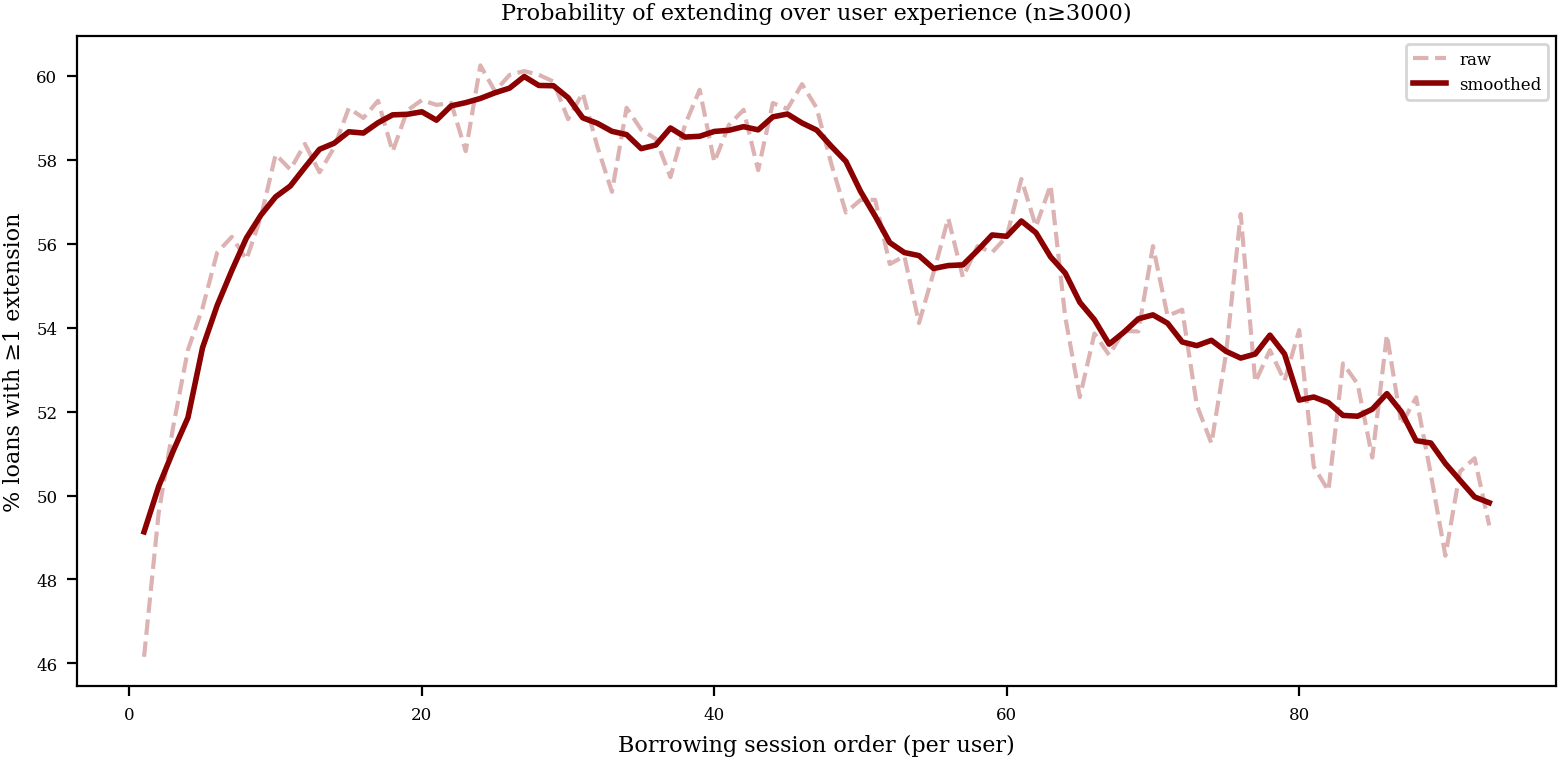

In [10]:
EXTENSION_COL = "Anzahl_Verlängerungen"
MIN_OBS = 3000
SMOOTH_WINDOW = 6

extension_data_frame = df_user_sessions.copy()
extension_data_frame["ext"] = pd.to_numeric(extension_data_frame[EXTENSION_COL], errors="coerce").fillna(0)

extension_data_frame["extended"] = (extension_data_frame["ext"] >= 1).astype(int)

curve_prob = (
    extension_data_frame
    .groupby("session_index")["extended"]
    .agg(percentage_extended="mean", n_obs="count")
    .reset_index()
    .sort_values("session_index")
)

curve_prob = curve_prob[curve_prob["n_obs"] >= MIN_OBS].copy()
curve_prob["percentage_extended_smooth"] = (
    curve_prob["percentage_extended"]
    .rolling(window=SMOOTH_WINDOW, center=True, min_periods=1)
    .mean()
)

plt.figure(figsize=(8,4))
plt.plot(curve_prob["session_index"], 100*curve_prob["percentage_extended"], color="darkred", alpha=0.3, linestyle="--", label="raw")
plt.plot(curve_prob["session_index"], 100*curve_prob["percentage_extended_smooth"], color="darkred", linewidth=2, label="smoothed")
plt.xlabel("Borrowing session order (per user)")
plt.ylabel("% loans with ≥1 extension")
plt.title(f"Probability of extending over user experience (n≥{MIN_OBS})")
plt.legend()
plt.tight_layout()
plt.show()


There seems to be an interesting increase in the extension rate during the early borrowing sessions. From the first to the 25th session, the share of loans with at least one extension rises by about 10 percentage points. Note that the overall extension rate is still quite low.

But does the exact number of extensions matter. We look at some interesting thresholds.

/tmp/ipykernel_166140/945518973.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


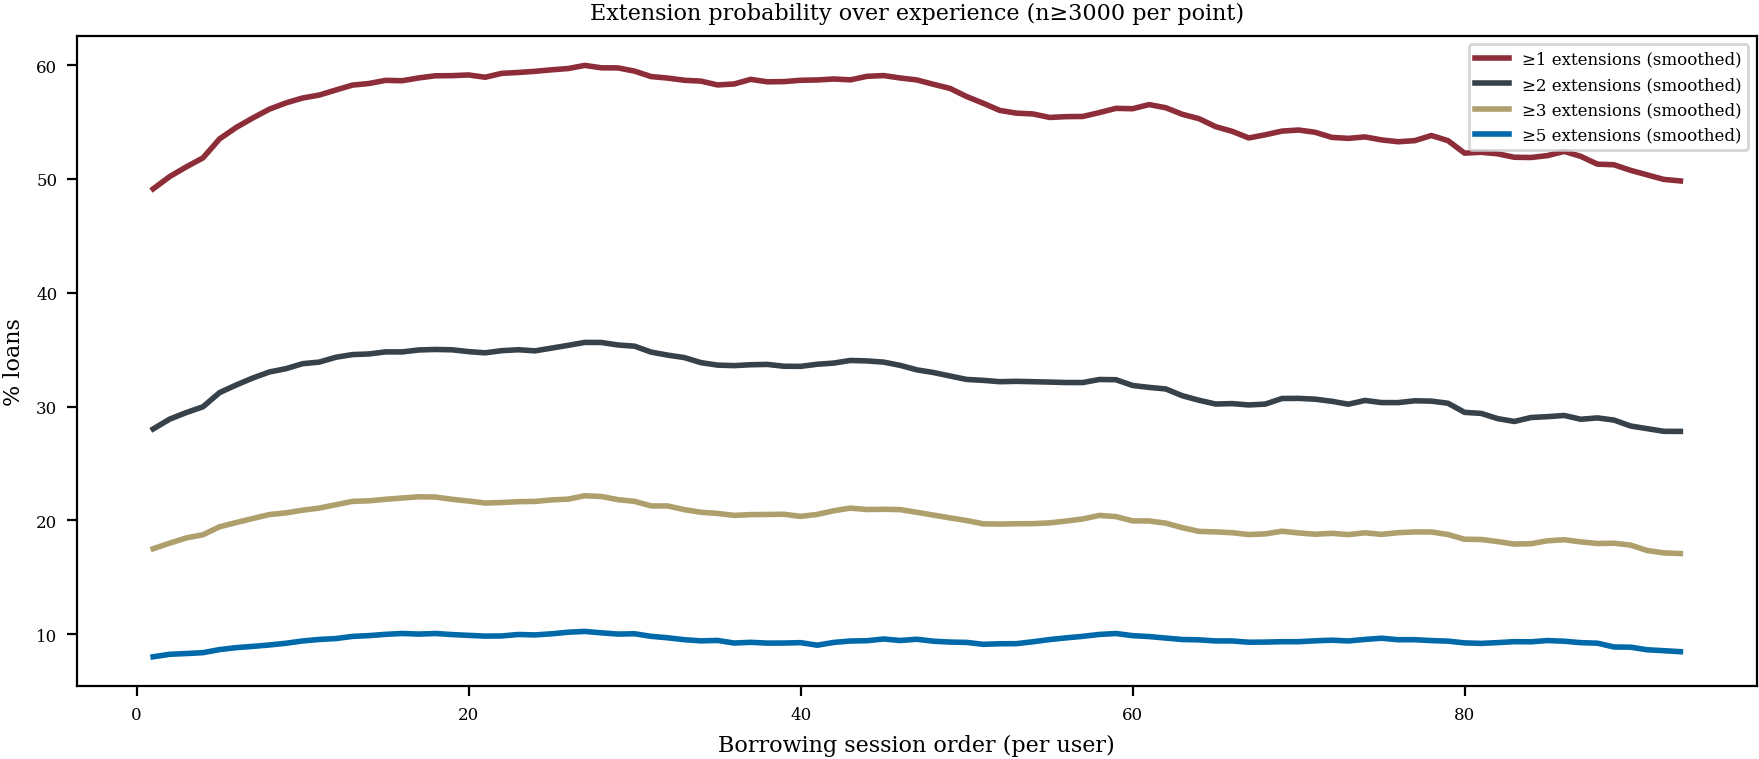

In [11]:
THRESHOLDS = [1, 2, 3, 5]

extension_data_frame = df_user_sessions.copy()
extension_data_frame["ext"] = pd.to_numeric(extension_data_frame[EXTENSION_COL], errors="coerce").fillna(0)

out = []
for k in THRESHOLDS:
    tmp = (
        extension_data_frame.assign(flag=(extension_data_frame["ext"] >= k).astype(int))
        .groupby("session_index")["flag"]
        .agg(rate="mean", n_obs="count")
        .reset_index()
        .sort_values("session_index")
    )
    tmp = tmp[tmp["n_obs"] >= MIN_OBS].copy()
    tmp["rate_smooth"] = tmp["rate"].rolling(SMOOTH_WINDOW, center=True, min_periods=1).mean()
    tmp["k"] = k
    out.append(tmp)

curve_k = pd.concat(out, ignore_index=True)

plt.figure(figsize=(9,4))
for k in THRESHOLDS:
    d = curve_k[curve_k["k"] == k]
    plt.plot(d["session_index"], 100*d["rate_smooth"], linewidth=2, label=f"≥{k} extensions (smoothed)")
plt.xlabel("Borrowing session order (per user)")
plt.ylabel("% loans")
plt.title(f"Extension probability over experience (n≥{MIN_OBS} per point)")
plt.legend()
plt.tight_layout()
plt.show()


The initial increase seems more pronounced when focusing on lower extension thresholds.

Now we look how if this effect is observable in different categories. We define the following plotting function.

In [12]:
def plot_extension_probability_curves_with_categories(
        input_data,
        target_column,
        category_filter,
        show_raw=True,
        min_observations=3000,
        smooth_window=6,
        cutoff=None
):
    filtered_data = input_data[input_data[target_column].isin(category_filter)].copy()

    filtered_data["ext"] = pd.to_numeric(filtered_data[EXTENSION_COL], errors="coerce").fillna(0)
    filtered_data["ext_ge_1"] = (filtered_data["ext"] >= 1).astype(int)

    aggregated_data = (
        filtered_data
        .groupby([target_column, "session_index"])["ext_ge_1"]
        .agg(rate="mean", n_obs="count")
        .reset_index()
        .sort_values([target_column, "session_index"])
    )

    max_sessions = (
        aggregated_data[aggregated_data["n_obs"] >= min_observations]
        .groupby(target_column)["session_index"]
        .max()
    )

    missing = [c for c in category_filter if c not in max_sessions.index]
    if missing:
        print(f"Dropping categories that don't reach min_observations={min_observations}: {missing}")
        category_filter = [c for c in category_filter if c in max_sessions.index]

    max_sessions = max_sessions.loc[category_filter]

    cutoff_to_use = int(max_sessions.min()) if cutoff is None else int(cutoff)

    aggregated_data = aggregated_data[aggregated_data["session_index"] <= cutoff_to_use].copy()
    aggregated_data = aggregated_data[aggregated_data["n_obs"] >= min_observations].copy()

    aggregated_data["rate_smooth"] = (
        aggregated_data
        .groupby(target_column)["rate"]
        .transform(lambda s: s.rolling(window=smooth_window, center=True, min_periods=1).mean())
    )

    # plot
    cycle_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", []) or ["C0","C1","C2","C3","C4"]

    plt.figure(figsize=(9, 4))

    for i, cat in enumerate(category_filter):
        d = aggregated_data[aggregated_data[target_column] == cat]
        if d.empty:
            continue

        color = cycle_colors[i % len(cycle_colors)]

        if show_raw:
            plt.plot(d["session_index"], 100 * d["rate"],
                     color=color, alpha=0.25, linestyle="--", label=f"{cat} (raw)")

        plt.plot(d["session_index"], 100 * d["rate_smooth"],
                 color=color, linewidth=2, linestyle="-", label=f"{cat} (smoothed)")

    plt.xlabel("Borrowing session order (per user)")
    plt.ylabel("% loans with ≥1 extension")
    plt.title(f"Extension probability by {target_column} (up to session {cutoff_to_use}, n≥{min_observations} per point)")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Do extensions differ in User Categories

/tmp/ipykernel_166140/782169480.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


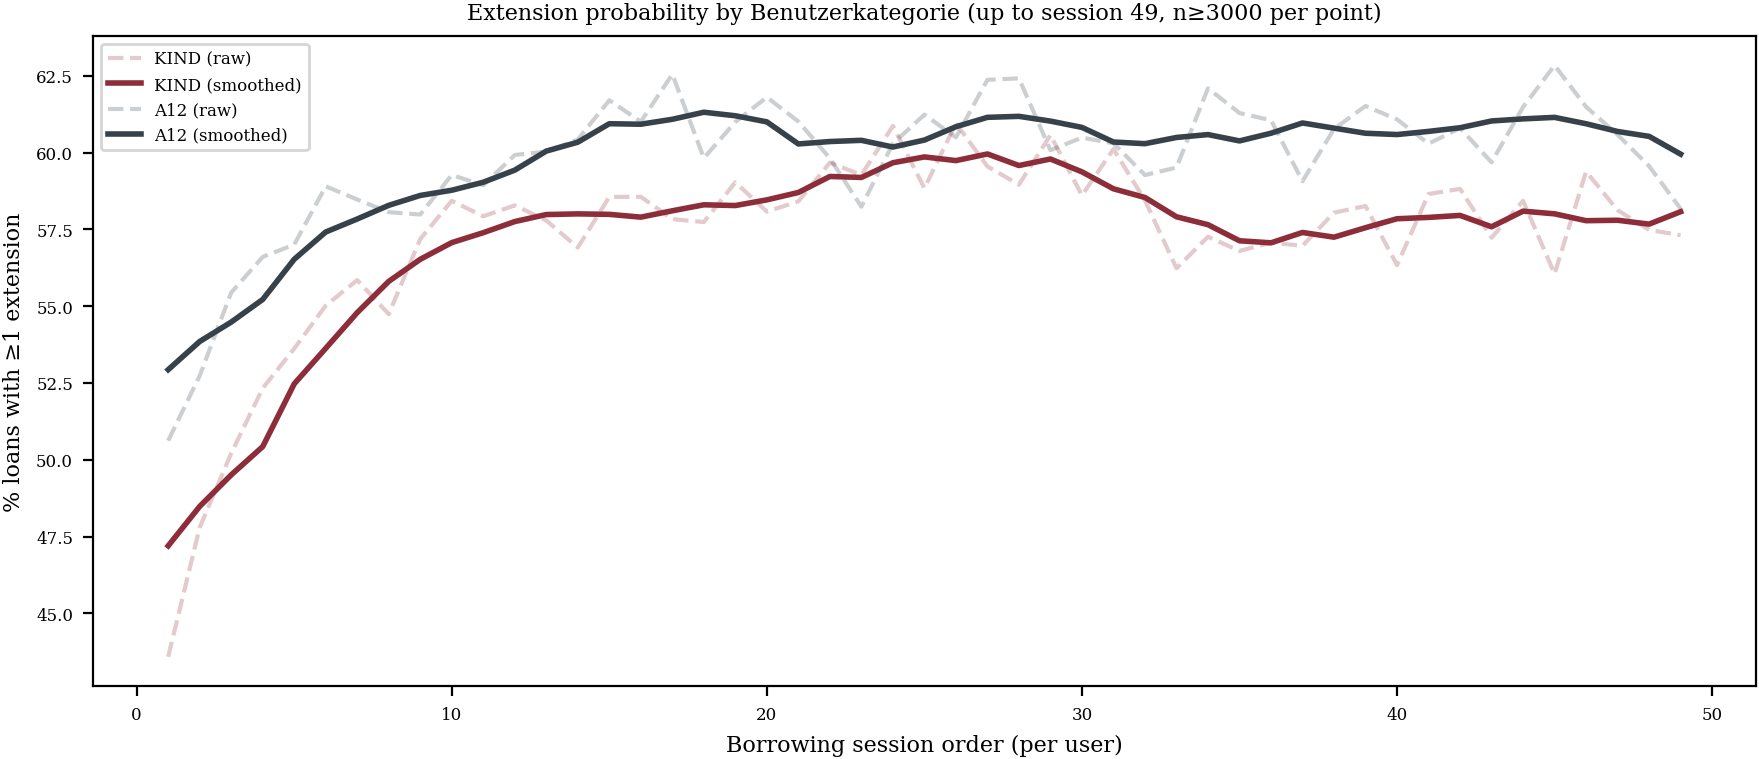

In [14]:
plot_extension_probability_curves_with_categories(df_user_sessions, USER_CATEGORY_COL, ["KIND", "A12"])

Adults seem to extend more often in comparison to kids. The curves look pretty similar

## Do extensions differ in Media Types

Dropping categories that don't reach min_observations=200: ['Zeitschriften']


/tmp/ipykernel_166140/782169480.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


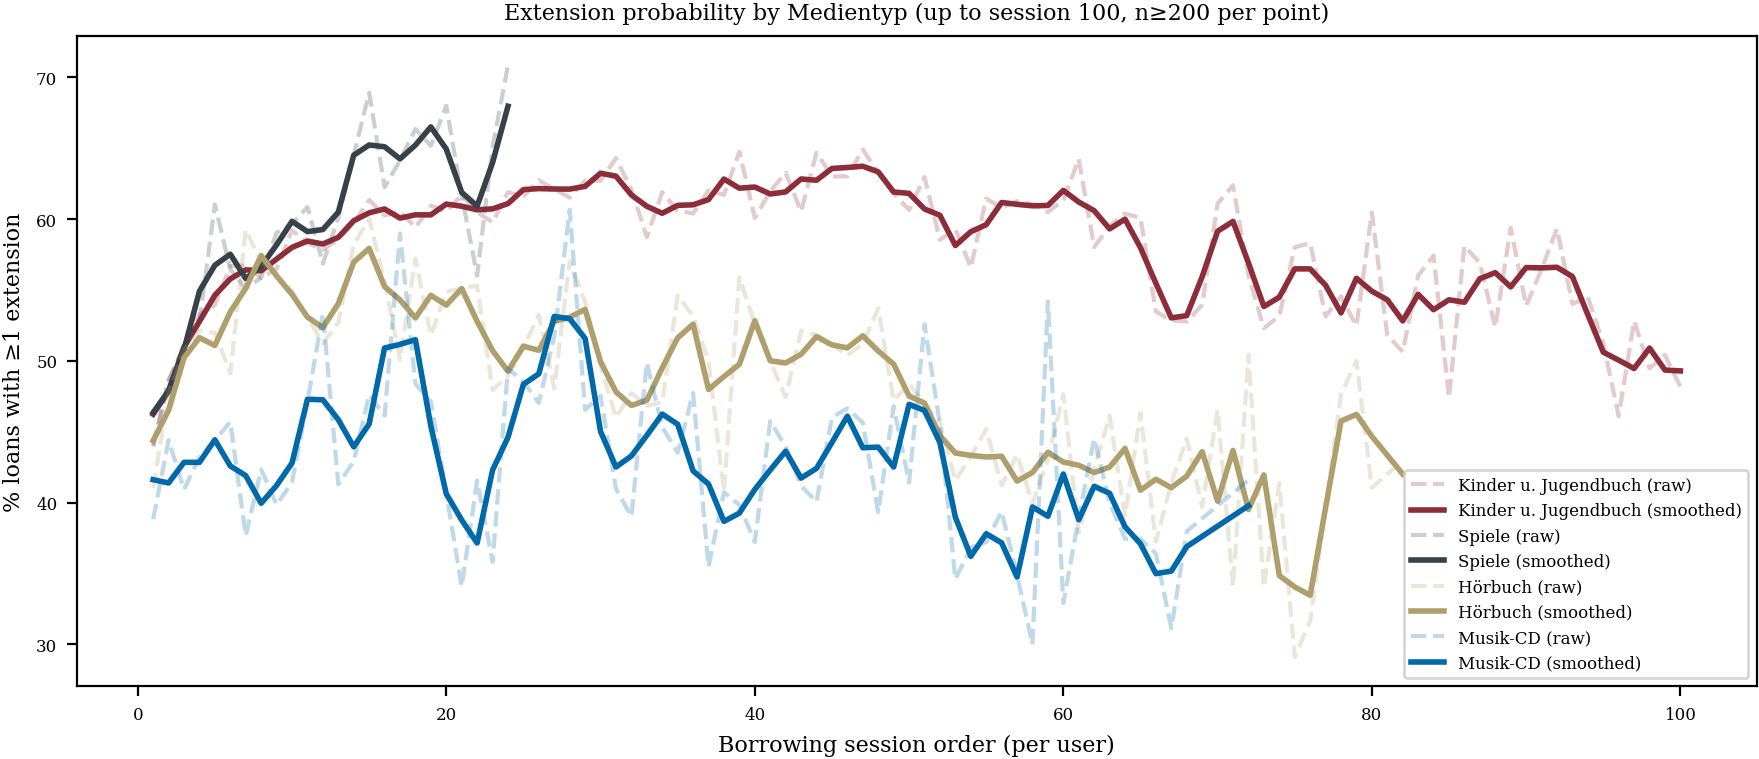

In [15]:
interesting_types = ["Kinder u. Jugendbuch", "Spiele", "Hörbuch", "Musik-CD",  "Zeitschriften"]

plot_extension_probability_curves_with_categories(
    df_user_sessions,
    target_column="Medientyp",
    category_filter=interesting_types,
    min_observations=200,
    smooth_window=3,
    cutoff=100,
)

The curve is visible in almost all categories. One possible outlier is “Musik-CD,” which does not appear to show the characteristic early-session pattern.

## Do more experienced users loan more items at once?
One reason for the increase of extensions could be that user tend to loan more at once after a few sessions. We look at this behavior in the following plot.

/tmp/ipykernel_166140/3049699867.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


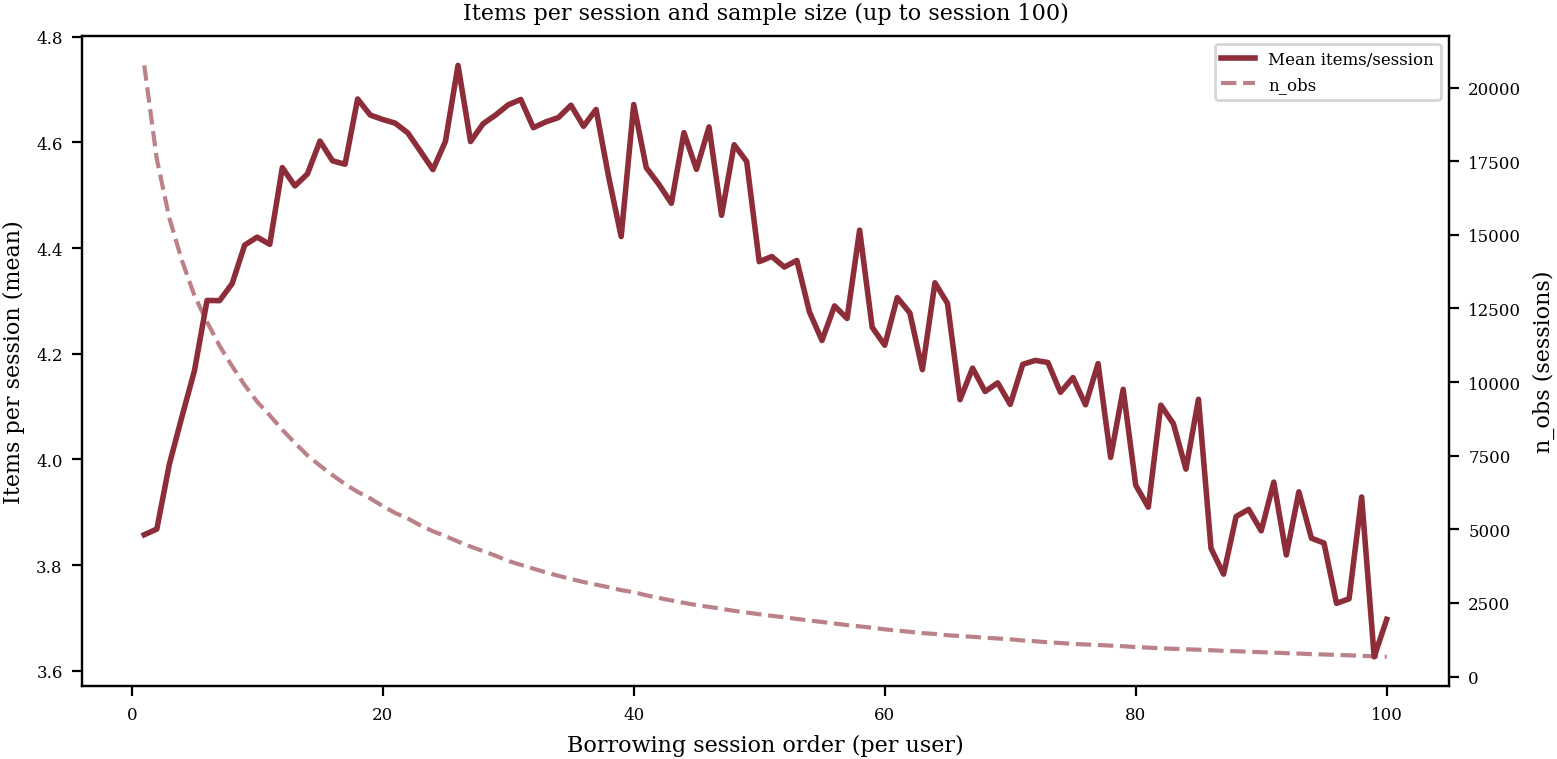

In [16]:
session = (
    df_user_sessions
    .groupby([USER_ID_COL, "issue_session"])
    .size()
    .rename("n_items_in_session")
    .reset_index()
)
session = session.merge(
    df_user_sessions[[USER_ID_COL, "issue_session", "session_index"]].drop_duplicates(),
    on=[USER_ID_COL, "issue_session"],
    how="left"
)

curve = (
    session.groupby("session_index")["n_items_in_session"]
    .agg(mean="mean", median="median", n_obs="count")
    .reset_index()
)

curve = curve[curve["session_index"] <= 100].copy()

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(curve["session_index"], curve["mean"], linewidth=2, label="Mean items/session")
ax1.set_xlabel("Borrowing session order (per user)")
ax1.set_ylabel("Items per session (mean)")

ax2 = ax1.twinx()
ax2.plot(curve["session_index"], curve["n_obs"], linestyle="--", alpha=0.6, label="n_obs")
ax2.set_ylabel("n_obs (sessions)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title(f"Items per session and sample size (up to session 100)")
plt.tight_layout()
plt.show()

The increase at the beginning could be an explanation for the increase in extensions